In [1]:
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2
from tqdm import tqdm
from arguments import ModelParams, PipelineParams, ModelHiddenParams
from scene import Scene, GaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_segmentation, render_mask
from utils.sh_utils import SH2RGB
import imageio
from utils.segment_utils import *

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Hyper-parameters

In [2]:
DATA_ROOT = '../data/dynerf/flame_steak'
MODEL_PATH = './output/dynerf/flame_steak'
CFG_PATH = './arguments/dynerf/flame_steak.py'
FEATURE_DIM = 32
CAM_VIEW = "cam16"

## Data and Model Preparation

In [3]:
parser = ArgumentParser(description="Render script parameters")
model = ModelParams(parser, sentinel=True)
# op = OptimizationParams(parser)
pipeline = PipelineParams(parser)
hp = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument('--mode', default='feature', choices=['scene', 'feature'])
parser.add_argument("--configs", type=str, default = CFG_PATH)
# parser.add_argument('--precomputed_mask', default=None, type=str)
args = get_combined_args(parser, MODEL_PATH, 'feature')
if args.configs:
    import mmcv
    from utils.params_utils import merge_hparams
    config = mmcv.Config.fromfile(args.configs)
    args = merge_hparams(args, config)

dataset = model.extract(args)
hyperparam = hp.extract(args)
dataset.object_masks = True
# dataset.need_gt_masks = True

gaussians = GaussianModel(dataset.sh_degree, args.mode, hyperparam, dataset.feature_dim)
scene = Scene(dataset, gaussians, load_iteration=args.iteration, mode=args.mode, cam_view=CAM_VIEW)

Looking for config file in ./output/dynerf/flame_steak/feature_cfg_args
Config file found at: ./output/dynerf/flame_steak/feature_cfg_args
ID Encoding Dimension:  32
mode:  feature
Loading trained model at iteration 14000
meta data loaded, total image:300
meta data loaded, total image:300
load finished. Train Dataset Length: 300


100%|██████████| 300/300 [00:00<00:00, 194360.70it/s]
300it [00:00, 70295.60it/s]

origin points, 37765
after points, 37765
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [20.96438789 14.43809223 42.81179047] [-27.41521454 -18.42700958   6.00896609]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 20.9644,  14.4381,  42.8118],
        [-27.4152, -18.4270,   6.0090]])
loading model from exists./output/dynerf/flame_steak/point_cloud/iteration_14000


## Begin Segmentation

In [4]:
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
bg_feature = [0 for i in range(FEATURE_DIM)]
bg_feature = torch.tensor(bg_feature, dtype=torch.float32, device="cuda")

video_cameras = [i for i in scene.getVideoCameras()]
train_cams = [i for i in scene.getTrainCameras()]
cam_type = scene.dataset_type
print("There are",len(video_cameras),"views in the dataset.")

There are 300 views in the dataset.


In [5]:
def plot(img_list, num, axis=False):
    l = len(img_list)
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(img_list):
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        if axis == False:
            plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


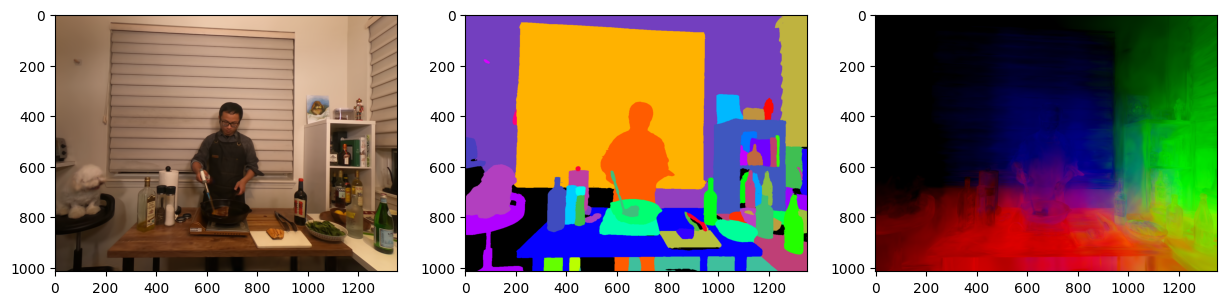

In [6]:
ref_img_camera_id = 0
mask_img_camera_id = 0
ref_view = train_cams[ref_img_camera_id]

with torch.no_grad():
    rendering = render(ref_view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    img = to8b(rendering).transpose(1,2,0)
    # img = cv2.resize(img, dsize=(1024,1024), fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
    objects = ref_view.objects
    
    identity_encoding = render_contrastive_feature(ref_view, gaussians, pipeline, bg_feature)["render"]
    logits = gaussians._classifier(identity_encoding)
    pred_obj = torch.argmax(logits,dim=0).cpu().numpy()
    
    import numpy as np
    from sklearn.decomposition import PCA
    identity_encoding = torch.nn.functional.normalize(identity_encoding, dim=0)
    X = identity_encoding.permute([1, 2, 0]).flatten(0, 1).cpu().numpy()
    np.random.seed(6)
    pca = PCA(n_components=3)
    pca.fit(X)
    X_rgb = pca.transform(X).reshape(*identity_encoding.shape[-2:], 3)
    # X_rgb = 255 * (X_rgb - X_rgb.min()) / (X_rgb.max() - X_rgb.min())
    
    plot([img, visualize_obj(pred_obj), X_rgb], 3, axis=True)

In [7]:
pred_obj[700, 100]

134

ID

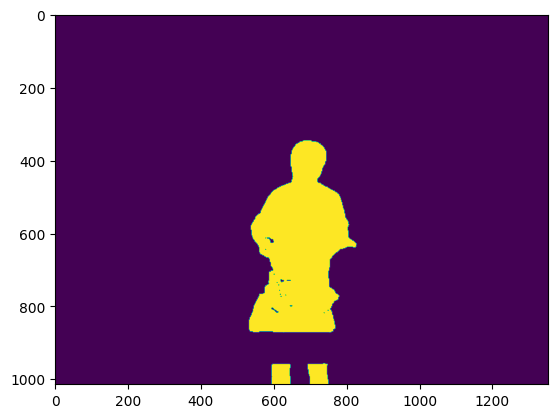

In [8]:
# dynerf/cut_roasted_beef


# dynerf/flame_steak
# cam03
# man = [61, 91, 98, 89]
# dog = [102]
# rice_cooker = [95]
# bottle = []

# cam16
man = [81, 67, 156, 169]
black_bottle = [75]
dog = [134]


selected_objects = man

selected_obj_ids = torch.tensor(selected_objects).cuda()
objects = ref_view.objects.cuda()
gt_mask = (objects[..., None] == selected_obj_ids[None, None, :])
gt_mask = gt_mask.any(dim=-1).squeeze().int()
plt.imshow(gt_mask.detach().cpu())

tensor(13344, device='cuda:0')


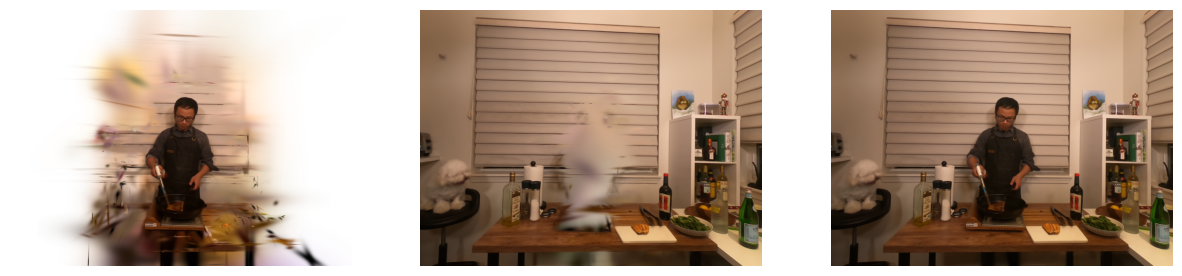

In [12]:
with torch.no_grad():
    means3D = gaussians.get_xyz
    ts = torch.tensor(ref_view.time).to(means3D.device).repeat(means3D.shape[0],1)
    
    identity_encoding = gaussians._mlp(means3D, ts)
    logits3d = gaussians._classifier(identity_encoding.unsqueeze(1).permute(2, 0, 1))
    prob_obj3d = torch.softmax(logits3d, dim=0)
    obj3d = torch.argmax(prob_obj3d, dim=0)
    hard_mask3d = (obj3d[..., None] == selected_obj_ids[None, :]).any(dim=-1).squeeze()
    soft_mask3d =  (prob_obj3d[selected_obj_ids, :, :] > 0.001).any(dim=0).squeeze()
    mask3d = hard_mask3d | soft_mask3d # hard_mask3d & soft_mask3d
    # mask3d = mask.any(dim=0).squeeze()
    print(mask3d.count_nonzero())
    
    # plot
    target_seg = render_segmentation(ref_view, gaussians, pipeline, bg_color, mask3d.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    target_del = render_segmentation(ref_view, gaussians, pipeline, bg_color, ~mask3d.bool())["render"]
    target_img_del = to8b(target_del.detach()).transpose(1,2,0)
    # rendered_mask = render_mask(ref_view, gaussians, pipeline, bg_color, precomputed_mask=mask3d.float())["mask"]
    # rendered_mask = rendered_mask.squeeze().detach().cpu()  > 0.1
    plot([target_img_seg, target_img_del, img], 3)

In [11]:
prob_thresh = 0.001
interval = 1

In [13]:
gaussians.create_mask_table((len(train_cams)+interval-1) // interval)
render_images = []
count = 0
with torch.no_grad():
    for idx, view in enumerate(tqdm(train_cams, desc="Rendering progress")):
        if idx % interval: continue
        if idx == 0: time1 = time.time()
        
        means3D = gaussians.get_xyz
        ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)
        identity_encoding = gaussians._mlp(means3D, ts)
        logits3d = gaussians._classifier(identity_encoding.unsqueeze(1).permute(2, 0, 1))
        prob_obj3d = torch.softmax(logits3d, dim=0)
        obj3d = torch.argmax(prob_obj3d, dim=0)
        hard_mask3d = (obj3d[..., None] == selected_obj_ids[None, :]).any(dim=-1).squeeze()
        soft_mask3d =  (prob_obj3d[selected_obj_ids, :, :] > prob_thresh).any(dim=0).squeeze()
        mask3d = hard_mask3d | soft_mask3d # hard_mask3d & soft_mask3d
        
        gaussians._time_map[count] = view.time
        gaussians._mask_table[count] = ~mask3d
        
        rendering = render_segmentation(view, gaussians, pipeline, bg_color, ~mask3d.bool())["render"]
        render_images.append(to8b(rendering.detach()).transpose(1,2,0))
        
        count += 1

time2 = time.time()
print("time:", time2 - time1)

Rendering progress: 100%|██████████| 300/300 [00:08<00:00, 36.84it/s]

time: 8.144960403442383


In [14]:
render_images = []
with torch.no_grad():
    for idx, view in enumerate(tqdm(video_cameras, desc="Rendering progress")):
        if idx == 0: time1 = time.time()
        
        # nearest interpolate
        diff = torch.abs(gaussians._time_map - view.time)
        index = torch.argmin(diff)
        mask = gaussians._mask_table[index]
            
        rendering = render_segmentation(view, gaussians, pipeline, bg_color, mask.bool())["render"]
        render_images.append(to8b(rendering.detach()).transpose(1,2,0))
        
time2 = time.time()
print("FPS:", len(video_cameras) / (time2 - time1))
torch.cuda.empty_cache()
    
imageio.mimwrite('demo/del_flame_steak.mp4', render_images, fps=30)

Rendering progress:   0%|          | 0/300 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 300/300 [00:06<00:00, 47.35it/s]


FPS: 47.34291799286145


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1352, 1014) to (1360, 1024) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5d13f40] Warning: data is not aligned! This can lead to a speed loss


In [15]:
hyper_param = {
    "prob_thresh": prob_thresh,
    "interval": interval
}
gaussians.save_mask_table(os.path.join(MODEL_PATH, "delete"), "flame_steak", hyper_param)
# gaussians.save_seg_gs(os.path.join(MODEL_PATH, "segment_results"))